In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using CUDA, BenchmarkTools
CUDA.allowscalar(false)

  Activating project at `~/cscs2023`
[ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]


# Kernel programming

When an array operation is not supported, or you need to perform an operation that you can easily express using existing array abstractions, you might need to write your own kernel. Kernels are **scalar functions that are executed multiple times in parallel**. Each 'thread' runs on one of the many streaming multiprocessors a GPU has, and threads running on a single SM are called a 'block'. Within a SM, some threads are always executed together; these form a 'warp' of 32 threads.

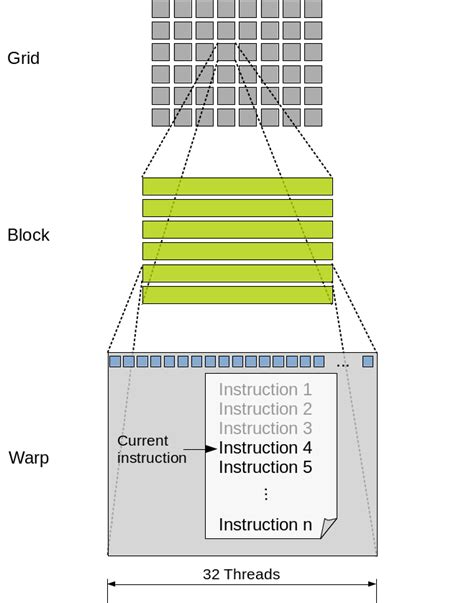

Key to using a GPU efficiently, is optimizing the communication between these entities:

- between blocks: global memory
- within a block: shared memory
- within a warp: via registers (shuffle)

But let's start with the basics.

## Defining and launching kernels

A kernel function is just a regular function in Julia, launched using the `@cuda` macro:

In [2]:
function my_kernel()
    return
end

@cuda my_kernel()

CUDA.HostKernel for my_kernel()

You can pass any argument to a CUDA kernel, as long as it's an `isbits` type:

In [3]:
function my_kernel(x)
    return
end

@cuda my_kernel(42)

CUDA.HostKernel for my_kernel(Int64)

In [4]:
@cuda my_kernel("42")

LoadError: GPU compilation of MethodInstance for my_kernel(::String) failed
KernelError: passing and using non-bitstype argument

Argument 2 to your kernel function is of type String, which is not isbits:



For some non-`isbits` arguments, such as `CuArray`, we have automatic conversions in place that make the arguments GPU-compatible:

In [5]:
A = CuArray([1,2,3])
isbits(A)

false

In [6]:
@cuda my_kernel(A)

CUDA.HostKernel for my_kernel(CuDeviceVector{Int64, 1})

## Launch configuration and indexing

Essential to a GPU, is launching multiple threads by setting the `threads` argument to `@cuda` and differentiating the computations by querying the current thread index:

In [7]:
function kernel(A)
    A[threadIdx().x] = threadIdx().x
    return
end

A = CUDA.zeros(10)
@cuda threads=length(A) kernel(A)
A

10-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

As threads are guaranteed to execute on the same shared multiprocessor, there's a limit on how many threads you can launch:

In [8]:
attribute(device(), CUDA.DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK)

1024

You can work around this by launching multiple blocks, which can be scheduled on different multiprocessors:

In [10]:
function kernel(A)
    i = (blockIdx().x-1) * blockDim().x + threadIdx().x
    if i <= length(A)
        # it's possible blockDim * gridDim > length(A)
        A[i] = (; thread=threadIdx().x, block=blockIdx().x)
    end
    return
end

A = CuArray{@NamedTuple{thread::Int, block::Int}}(undef, 10)
@cuda threads=5 blocks=2 kernel(A)
A

10-element CuArray{@NamedTuple{thread::Int64, block::Int64}, 1, CUDA.Mem.DeviceBuffer}:
 (thread = 1, block = 1)
 (thread = 2, block = 1)
 (thread = 3, block = 1)
 (thread = 4, block = 1)
 (thread = 5, block = 1)
 (thread = 1, block = 2)
 (thread = 2, block = 2)
 (thread = 3, block = 2)
 (thread = 4, block = 2)
 (thread = 5, block = 2)

Most of the time, it's best to rely on the CUDA APIs to determine a good launch configuration, using the occupancy API:

In [11]:
k = @cuda launch=false kernel(A)
@show config = launch_configuration(k.fun)
threads = min(length(A), config.threads)
blocks = cld(length(A), threads)
k(A; threads, blocks)
A

config = launch_configuration(k.fun) = (blocks = 112, threads = 1024)


10-element CuArray{@NamedTuple{thread::Int64, block::Int64}, 1, CUDA.Mem.DeviceBuffer}:
 (thread = 1, block = 1)
 (thread = 2, block = 1)
 (thread = 3, block = 1)
 (thread = 4, block = 1)
 (thread = 5, block = 1)
 (thread = 6, block = 1)
 (thread = 7, block = 1)
 (thread = 8, block = 1)
 (thread = 9, block = 1)
 (thread = 10, block = 1)

## Synchronization

If threads are working together -- say, they are using the same global memory, or are communicating using shared memory or finer-grained intrinsics -- you may need to have threads wait on each other. Note that this is only possible **within a block**; different blocks generally cannot wait on one another.

Let's look at a contrived example:

In [14]:
# simple reverse kernel without multiple blocks
function reverse_kernel(A)
    i = threadIdx().x
    if i <= length(A)
        j = length(A) - i + 1
        A[i] = A[j]
    end
    return
end

A = CuArray(1:100)
@cuda threads=length(A) reverse_kernel(A)
Array(A) == 100:-1:1

true

Depending on how the threads get scheduled, values may get read after they have been written to by another thread. The solution is to wait for all threads to have read a value before writing to it again:

In [17]:
# simple reverse kernel without multiple blocks
function reverse_kernel(A)
    i = threadIdx().x
    if i <= length(A)
        j = length(A) - i + 1
        val = A[j]
    end
    sync_threads()
    if i <= length(A)
        A[i] = val
    end
    return
end

A = CuArray(1:100)
@cuda threads=length(A) reverse_kernel(A)
Array(A) == 100:-1:1

true

Note how we didn't put `sync_threads()` inside of the branch; All threads need to reach the synchronization point for the kernel to make progress. This makes it dangerous to synchronize from a branch, as the branch cannot be divergent within a block or the kernel would deadlock!

When coordinating within the warp, you may need the `sync_warp()` function. A detailed explanation of warp-level programming is out of scope for this notebook, refer to the [NVIDIA developer blog](https://developer.nvidia.com/blog/using-cuda-warp-level-primitives/) for more information.

## Shared memory

As mentioned before, one of the crucial aspects of GPU programming is efficient communication between threads, where efficient means that we're using the optimal memory hierarchy for the job, instead of always hitting global device memory.

For threads that execute in a block, which will be scheduled on a single shared multiprocessor, it's possible to allocate shared memory that can be accessed by all threads.

For example, let's update the `reverse` kernel to use shared memory:

In [18]:
function reverse_kernel(A::AbstractVector{T}) where T
    i = threadIdx().x
    j = length(A) - i + 1
    buf = CuStaticSharedArray(T, 100)
    buf[i] = A[i]
    sync_threads()
    A[i] = buf[j]
    return
end

A = CuArray(1:100)
@cuda threads=length(A) reverse_kernel(A)
Array(A) == 100:-1:1

true

With static shared memory, we have to hardcode the size of the shared array. That's often OK, because the size of the thread block is often known (or bounded). In case it isn't, we can use dynamic shared memory, which requires setting the `shmem` keyword argument to `@cuda` to a number of bytes:

In [19]:
function reverse_kernel(A::AbstractVector{T}) where T
    i = threadIdx().x
    j = length(A) - i + 1
    buf = CuDynamicSharedArray(T, length(A))
    buf[i] = A[i]
    sync_threads()
    A[i] = buf[j]
    return
end

A = CuArray(1:100)
@cuda threads=length(A) shmem=sizeof(A) reverse_kernel(A)
Array(A) == 100:-1:1

true

Note that we still passed the (dynamic) length of the array to the `CuDynamicSharedArray` constructor, which makes it possible to bounds-check accesses. 

## Atomic operations

When you want to use the same global memory from different threads, you may want to use atomic operations. For example:

In [20]:
A_sum = CUDA.zeros(1)
A = CUDA.rand(512)

function kernel(A, A_sum)
    i = threadIdx().x
    CUDA.@atomic A_sum[] += A[i]
    return
end
@cuda threads=length(A) kernel(A, A_sum)
Array(A_sum)[]

241.49663f0

You shouldn't overuse atomics though, as they generally serialize execution and thus are very expensive! But they may be useful for an initial implementation (i.e. before considering more fine-grained communication), or to reduce values from different blocks (because of the difficulty of synchronizing the grid).

## Output

To help with implementing a kernel, there's a couple of helpful macros to generate output:

In [21]:
function kernel()
    i = threadIdx().x
    @cuprintf "I'm thread %ld\n" Int(i)
    return
end
@cuda kernel();

I'm thread 1


However, `@cuprintf` is a bit cumbersome, so we have `@cuprintln` trying to automatically generate an appropriate formatting string, while even supporting string interpolation:

In [22]:
function kernel()
    i = threadIdx().x
    @cuprintln "I'm thread $i"
    return
end
@cuda kernel();

I'm thread 1


And for quick debugging, we have a helpful `@cushow` you can surround expressions with:

In [23]:
function kernel()
    i = @cushow threadIdx().x
    return
end
@cuda kernel();

(threadIdx()).x = 1


## Other CUDA features

CUDA.jl supports many other device-side CUDA features, like cooperative groups, dynamic parallelism, warp functions, etc. Some high-level Julia features are also supported in device context, such as random number generation and 

## Common issues

Because some aspects of the Julia language are unsupported, you'll definitely be running into compilation errors when writing GPU device code. With CPU code, Julia being a dynamic language, errors are postponed to run-time, so if you have a typo in your code it will still compile but you will run into an error at run time.

With GPU code, it's harder to report errors at run time (for one, they'd be generated by every thread, resulting in a multiplication of errors), so the GPU compiler generally refuses to compile when it encounters certain unsupported code patterns. In other cases, errors are reported, but they are much less informative than on the CPU.

<div class="alert alert-block alert-info">
    <b>Note</b>: Work is under way to improve the ability for GPU code to call into the CPU for, e.g., dynamic error reporting. That would make it possible to compile unsupported code and have it error at run time just like Julia code on the CPU.
</div>

Let's demonstrate a couple of common errors:

### Returning values from kernels

Kernel functions cannot return anything; if you do so you'll run into a compilation error:

In [24]:
kernel() = 42
@cuda kernel()

LoadError: GPU compilation of MethodInstance for kernel() failed
KernelError: kernel returns a value of type `Int64`

Make sure your kernel function ends in `return`, `return nothing` or `nothing`.


If you need to return a value from a kernel, use a single-element `CuArray`, or a `Ref`:

In [25]:
function kernel(A)
    A[1] = 42
    return
end

A = CuArray([0])
@cuda kernel(A)
A

1-element CuArray{Int64, 1, CUDA.Mem.DeviceBuffer}:
 42

In [26]:
function kernel(ref)
    ref[] = 42
    return
end

ref = Ref(0)
@cuda kernel(ref)
ref

Base.RefValue{Int64}(42)

### Run-time exceptions

When a kernel runs into an exception, there's two issues that may make resolving the exception harder than on the CPU:

- because kernels execute asynchronously, the exception will only be caught during a subsequent synchronizing API call;
- much of the information of the exception will have been lost (notably custom printing, and sometimes even the exception type).

For example:

In [27]:
function kernel(a)
    if threadIdx().x == 1
        a[] += 42.1
    end
    return
end
@cuda kernel(CuArray([42]))

CUDA.HostKernel for kernel(CuDeviceVector{Int64, 1})

ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.


Here, execution of the kernel already indicated something went wrong by printing information to the console, but we haven't "trapped" the exception yet. That only happepns on a subsequent API call, such as `synchronize()`:

In [28]:
synchronize()

LoadError: KernelException: exception thrown during kernel execution on device Tesla P100-PCIE-16GB

The best way to debug this, is by starting Julia with `-g2` so that the device-side output will include a stack trace:

```
$ julia -g2
...
julia> @cuda kernel(CuArray([42]))
ERROR: a exception was thrown during kernel execution.
Stacktrace:
 [1] Int64 at ./float.jl:812
 [2] convert at ./number.jl:7
 [3] setindex! at /home/tim/Julia/pkg/CUDA/src/device/array.jl:204
 [4] setindex! at /home/tim/Julia/pkg/CUDA/src/device/array.jl:217
 [5] kernel at ./REPL[1]:3
```

### Unsupported IR

Other errors might result in a failure later during compilation:

In [29]:
function kernel(a)
    if threadId().x == 1
        a[] = 42
    end
    return
end
@cuda kernel(CuArray([1]))

LoadError: InvalidIRError: compiling MethodInstance for kernel(::CuDeviceVector{Int64, 1}) resulted in invalid LLVM IR
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
[31mReason: unsupported use of an undefined name[39m[31m (use of 'threadId')[39m
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @[39m [90m./[39m[90m[4mIn[29]:2[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
[31mReason: unsupported dynamic function invocation[39m
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @[39m [90m./[39m[90m[4mIn[29]:2[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to getproperty)[39m
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @[39m [90m./[39m[90m[4mIn[29]:2[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to ==)[39m
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @[39m [90m./[39m[90m[4mIn[29]:2[24m[39m
[36m[1mHint[22m[39m[36m: catch this exception as `err` and call `code_typed(err; interactive = true)` to introspect the erronous code with Cthulhu.jl[39m

CUDA.jl tries its best to figure out why dynamic IR was generated, as can be seen in the error trace here. It's also possible to spot this error using reflection macros (more on those later):

In [30]:
@device_code_warntype @cuda kernel(CuArray([1]))

PTX CompilerJob of MethodInstance for kernel(::CuDeviceVector{Int64, 1}) for sm_60

MethodInstance for kernel(::CuDeviceVector{Int64, 1})
  from kernel(a) @ Main In[29]:1
Arguments
  #self#::Core.Const(kernel)
  a::CuDeviceVector{Int64, 1}
Body::Nothing
1 ─ %1 = Main.threadId()::Any
│   %2 = Base.getproperty(%1, :x)::Any
│   %3 = (%2 == 1)::Any
└──      goto #3 if not %3
2 ─      Base.setindex!(a, 42)
3 ┄      return nothing



LoadError: InvalidIRError: compiling MethodInstance for kernel(::CuDeviceVector{Int64, 1}) resulted in invalid LLVM IR
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.new_gc_frame)[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.push_gc_frame)[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.pop_gc_frame)[39m
[31mReason: unsupported use of an undefined name[39m[31m (use of 'threadId')[39m
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @[39m [90m./[39m[90m[4mIn[29]:2[24m[39m
[31mReason: unsupported call to an unknown function[39m[31m (call to julia.get_gc_frame_slot)[39m
[31mReason: unsupported dynamic function invocation[39m
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @[39m [90m./[39m[90m[4mIn[29]:2[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to getproperty)[39m
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @[39m [90m./[39m[90m[4mIn[29]:2[24m[39m
[31mReason: unsupported dynamic function invocation[39m[31m (call to ==)[39m
Stacktrace:
 [1] [0m[1mkernel[22m
[90m   @[39m [90m./[39m[90m[4mIn[29]:2[24m[39m
[36m[1mHint[22m[39m[36m: catch this exception as `err` and call `code_typed(err; interactive = true)` to introspect the erronous code with Cthulhu.jl[39m

In this IR, the `::Any` indicates that type-unstable code will be generated. This is unsupported on the GPU, as it will result in calls to the runtime library.

### Passing invalid types

Compilation errors are not limited to kernel functions, you can trigger some by using array abstractions in an invalid manner. For example:

In [31]:
CuArray([1]) .= [1]

LoadError: GPU compilation of MethodInstance for (::GPUArrays.var"#broadcast_kernel#38")(::CUDA.CuKernelContext, ::CuDeviceVector{Int64, 1}, ::Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{1}, Tuple{Base.OneTo{Int64}}, typeof(identity), Tuple{Base.Broadcast.Extruded{Vector{Int64}, Tuple{Bool}, Tuple{Int64}}}}, ::Int64) failed
KernelError: passing and using non-bitstype argument

Argument 4 to your kernel function is of type Base.Broadcast.Broadcasted{CUDA.CuArrayStyle{1}, Tuple{Base.OneTo{Int64}}, typeof(identity), Tuple{Base.Broadcast.Extruded{Vector{Int64}, Tuple{Bool}, Tuple{Int64}}}}, which is not isbits:
  .args is of type Tuple{Base.Broadcast.Extruded{Vector{Int64}, Tuple{Bool}, Tuple{Int64}}} which is not isbits.
    .1 is of type Base.Broadcast.Extruded{Vector{Int64}, Tuple{Bool}, Tuple{Int64}} which is not isbits.
      .x is of type Vector{Int64} which is not isbits.



Here, compilation fails because GPU code requires all arguments to be `isbits` (remember the difference between `CuArray` and `CuDeviceArray`).

## Exercise: Matrix RMSE

Now that we know something about implementing kernels, and debugging issues with them, let's try implementing the RMSE function again:

$$
    RMSE = \sqrt{\frac{1}{N} \sum_{i=1}^N (A_i - B_i)^2}
$$

Recall that we implemented it using array operations as such:

In [32]:
rmse(A, B) = sqrt(sum((A.-B).^2) / length(A))

rmse (generic function with 1 method)

Let's start with an simplified implementation:

- only use a single block
- use a single-element array to store the result
- compute $(A_i - B_i)^2$ on all threads, storing the result in global memory

Try to keep the number of API calls and kernel launches to a minimum, i.e., perform as many operations as possible in a single kernel.

In [37]:
A = rand(512)
B = rand(512)
rmse(A, B)

0.3914029497263703

In [42]:
dA = CuArray(A)
dB = CuArray(B)
dC = similar(dA, 1);

A possible implementation would look as follows:

In [43]:
function rmse_kernel(C, A, B)
    i = threadIdx().x

    # initialize the memory
    if i == 1
        C[] = 0
    end
    sync_threads()

    # process an element on each thread
    a = A[i]
    b = B[i]
    CUDA.@atomic C[] += (a-b)^2
    sync_threads()

    # finalize the computation
    if i == 1
        C[1] = sqrt(C[] / length(A))
    end
    return
end

@cuda threads=length(dA) rmse_kernel(dC, dA, dB)
CUDA.@allowscalar dC[]

0.3914029497263704

As we've seen before, this kernel will run into an error when it tries to launch too many threads. Instead, we need to use the launch configuration API to make sure we use a valid launch configuration:

In [44]:
function rmse_kernel(C, A, B)
    i = (blockIdx().x-1) * blockDim().x + threadIdx().x

    # initialize the memory
    if i == 1
        C[] = 0
    end
    sync_threads()

    # process an element on each thread
    a = A[i]
    b = B[i]
    CUDA.@atomic C[] += (a-b)^2
    sync_threads()

    # finalize the computation
    if i == 1
        C[1] = sqrt(C[] / length(A))
    end
    return
end

k = @cuda launch=false rmse_kernel(dC, dA, dB)
config = CUDA.launch_configuration(k.fun)
threads = min(length(A), config.threads)
blocks = cld(length(A), threads)
k(dC, dA, dB; threads, blocks)

CUDA.@allowscalar dC[]

0.39140294972637024

Things break! Turns out this generalization isn't always valid, here because we performed an initialization and finalization step on thread 1, however, now that we launch multiple blocks that thread does not longer run in lockstep with all other steps. As a result, we need to perform these operations before and after the kernel, from the host:

In [48]:
function rmse_kernel(C, A, B)
    i = (blockIdx().x-1) * blockDim().x + threadIdx().x

    if i > length(A)
        return
    end

    # process an element on each thread
    a = A[i]
    b = B[i]
    CUDA.@atomic C[] += (a-b)^2

    return
end

dC .= 0                                     # <-- initialization

k = @cuda launch=false rmse_kernel(dC, dA, dB)
config = CUDA.launch_configuration(k.fun)
threads = min(length(A), config.threads)
blocks = cld(length(A), threads)
k(dC, dA, dB; threads, blocks)

CUDA.@allowscalar sqrt(dC[] / length(A))    # <-- finalization

0.39140294972637046

An alternative is to generalize using a so-called grid stride loop, i.e., by having each thread process multiple elements until we exhaust the input. That means converting the following pattern:

```julia

function kernel(input)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x

    if i <= length(input)
        # do something with input[i]
    end

    return
end
```

to:

```julia
function kernel(input)
    i = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = blockDim().x * gridDim().x

    while i <= length(input)
        # do something with input[i]
        i += stride
    end

    return
end
```

Note that for our simplified kernel that only uses a single block, `i` and `stride` are simply `threadIdx().x` and `blockDim().x`.

In [49]:
function rmse_kernel(C, A, B)
    # initialize the memory
    if threadIdx().x == 1
        C[1] = 0
    end
    sync_threads()

    # grid-stride loop to process all elements
    i = threadIdx().x
    stride = blockDim().x
    while i <= length(A)
        a = A[i]
        b = B[i]
        CUDA.@atomic C[1] += (a-b)^2
        i += stride
    end
    sync_threads()

    # finalize the computation
    if threadIdx().x == 1
        C[1] = sqrt(C[1] / length(A))
    end
    return
end

@cuda threads=256 rmse_kernel(dC, dA, dB)
CUDA.@allowscalar dC[]

0.39140294972637035

Note how it doesn't matter anymore how many threads we launch, as the kernel adapts automatically. This is a very powerful pattern that generalizes kernel implementations, avoiding assumptions on the launch configuration.

**HOWEVER**, it is not all great. Recall the suggested launch configuration:

In [50]:
k = @cuda launch=false rmse_kernel(dC, dA, dB)
launch_configuration(k.fun)

(blocks = 112, threads = 1024)

The `blocks` in there is a suggestion on how many blocks we should launch to fully utilize our GPU. Meanwhile, we are only launching a single block, severely underutilizing our device! That doesn't mean grid stride loops are useless, as they keep our kernel flexible (dynamically adapting to the actual launch configuration), and making it possible to limit the number of blocks launched (which can sometimes hurt performance). So let's combine both approaches:

In [51]:
function rmse_kernel(C, A, B)
    i = (blockIdx().x-1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x

    # grid-stride loop to process all elements
    while i <= length(A)
        a = A[i]
        b = B[i]
        CUDA.@atomic C[] += (a-b)^2

        i += stride
    end

    return
end

dC .= 0

k = @cuda launch=false rmse_kernel(dC, dA, dB)
config = CUDA.launch_configuration(k.fun)
threads = min(length(A), config.threads)
blocks = cld(length(A), threads)
blocks = min(blocks, config.blocks)             # <-- avoid oversubscription
k(dC, dA, dB; threads, blocks)

CUDA.@allowscalar sqrt(dC[] / length(A))

0.39140294972637035

Let's finish up with a benchmark of different implementations. First, using array operations on the CPU:

In [58]:
A = rand(2048, 2048)
B = rand(2048, 2048)

@benchmark rmse($A, $B)

BenchmarkTools.Trial: 246 samples with 1 evaluation.
 Range (min … max):  18.846 ms … 24.527 ms  ┊ GC (min … max): 0.00% … 21.67%
 Time  (median):     19.004 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   20.319 ms ±  2.322 ms  ┊ GC (mean ± σ):  6.38% ±  9.21%

  ▆█                                                       ▆   
  ███▄▄▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁█▅ ▅
  18.8 ms      Histogram: log(frequency) by time      24.5 ms <

 Memory estimate: 32.00 MiB, allocs estimate: 4.

Then, the straightforward GPU port:

In [59]:
dA = CuArray(A)
dB = CuArray(B)
@benchmark rmse($dA, $dB)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  338.241 μs …   5.697 ms  ┊ GC (min … max): 0.00% … 14.54%
 Time  (median):     360.474 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   373.237 μs ± 209.246 μs  ┊ GC (mean ± σ):  0.45% ±  0.74%

               ▂▆▆▃     ▄▅▁                   █▆▁                
  ▁▁▂▂▅▆▇▆▆▃▂▃▄█████▅▃▂▆███▄▂▃▄▃▂▂▃▂▂▂▂▂▂▃▃▂▃████▄▃▂▂▂▂▂▂▂▁▁▁▁▁ ▃
  338 μs           Histogram: frequency by time          398 μs <

 Memory estimate: 6.23 KiB, allocs estimate: 113.

And finally, our custom kernel:

In [61]:
dC = similar(dA, 1)

k = @cuda launch=false rmse_kernel(dC, dA, dB)
config = CUDA.launch_configuration(k.fun)
threads = min(length(A), config.threads)
blocks = cld(length(A), threads)
blocks = min(blocks, config.blocks)

@benchmark CUDA.@sync k(dC, dA, dB; threads, blocks)

BenchmarkTools.Trial: 505 samples with 1 evaluation.
 Range (min … max):  9.883 ms … 9.941 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.901 ms             ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.901 ms ± 5.407 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▁                         ▅█▇▅▄▂   ▂                      
  ▆██▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆██████████▆▅▄▅▁▁▁▄▁▁▄▄▄▁▁▄▅▅▁▄ ▇
  9.88 ms     Histogram: log(frequency) by time     9.92 ms <

 Memory estimate: 1.20 KiB, allocs estimate: 23.

Well, that's unexpectedly slow! We'll look into why that is in the next notebook.

## High-level kernel programming

Before finishing this notebook, I want to namedrop a couple of packages that aim to simplify kernel programming without resorting to array operations (which generally aren't as flexible).

### Tullio.jl

With Tullio, it's easy to write kernels using index notation. This makes it easy to express operations like our RMSE calculation in a single expression which typically will also be compiled to a single kernel:

In [62]:
using Tullio

A = ones(10, 10)

# assigning with `:=` creates a new array
@tullio C[i,j] := A[i,j]

[ Info: Precompiling TullioCUDAExt [4e6b9f75-c769-5b50-88dd-0f9543e5de10]


10×10 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [63]:
# dropping an index will sum across that dimension
@tullio C[i] := A[i,j]

10-element Vector{Float64}:
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0

In [64]:
# pipe operators can be used to apply functions 'outside' of the reduction
@tullio C[] := A[i,j] |> log10(_)

0-dimensional Array{Float64, 0}:
2.0

With that explained, try to implement the matrix RMSE operation using index notation. Recall the original operation (first on CPU arrays):

In [65]:
A = rand(1024, 1024)
B = rand(1024, 1024)
sqrt(sum((A-B).^2)/length(A))

0.4084252657854481

Now with Tullio:

In [66]:
@tullio C[] := (A[i,j] - B[i,j])^2 |> sqrt(_ / length(A))


0-dimensional Array{Float64, 0}:
0.40842526578544525

To use Tullio on the GPU, we simply use CuArrays everywhere:

In [76]:
dA = CuArray(A)
dB = CuArray(B)
@tullio dC[] := (dA[i,j] - dB[i,j])^2 |> sqrt(_ / length(dA))

0-dimensional CuArray{Float64, 0, CUDA.Mem.DeviceBuffer}:
0.40804403168851916

Tullio is great for quickly creating portable kernels (CPU, different GPU back-ends) for mathematical operations, and it can be seen as a generalization of broadcast. Sadly, for the purpose of our RMSE kernel, it does not efficiently support reduction operations on the GPU.

### KernelAbstractions.jl

For a more flexible API, i.e. not restricted to Tullio's index notation, but still retaining Tullio's portability, you can consider the KernelAbstractions.jl framework that Tullio.jl is built on:

In [77]:
using KernelAbstractions

In [78]:
@kernel function ka_rmse_kernel(C, A, B)
    i = @index(Global)

    a = A[i]
    b = B[i]
    KernelAbstractions.@atomic C[] += (a-b)^2
end

ka_rmse_kernel (generic function with 4 methods)

In [79]:
A = rand(512, 512)
B = rand(512, 512)
@show rmse(A, B)

backend = CPU()
dA = KernelAbstractions.allocate(backend, eltype(A), size(A))
KernelAbstractions.copyto!(backend, dA, A)
dB = KernelAbstractions.allocate(backend, eltype(B), size(B))
KernelAbstractions.copyto!(backend, dB, B)
dC = KernelAbstractions.zeros(backend, eltype(A), 1)
@show typeof(dC)

k = ka_rmse_kernel(backend)
k(dC, dA, dB; ndrange=size(A))

sqrt(Array(dC)[] / length(A))

rmse(A, B) = 0.40829909701268036
typeof(dC) = Vector{Float64}


0.40829909701268235

The programming interface is now much closer to CUDA.jl's, while retaining platform portability!

In [80]:
backend = CUDABackend()
dA = KernelAbstractions.allocate(backend, eltype(A), size(A))
KernelAbstractions.copyto!(backend, dA, A)
dB = KernelAbstractions.allocate(backend, eltype(B), size(B))
KernelAbstractions.copyto!(backend, dB, B)
dC = KernelAbstractions.zeros(backend, eltype(A), 1)
@show typeof(dC)

k = ka_rmse_kernel(backend)
k(dC, dA, dB; ndrange=size(A))

sqrt(Array(dC)[] / length(A))

typeof(dC) = CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}


0.40829909701268174

The disadvantage of platform portability of course is that KernelAbstraction.jl's feature set is limited to the common denominator of all supported platforms. That means many CUDA features, like dynamic shared memory or warp-level programming, are not supported. The framework is also slightly opinionated wrt. indexing characteristics, so it's trickier to implement e.g. a grid-stride loop.